In [1]:
from pathlib import Path
from collections import Counter
from random import randint, seed

In [2]:
from _galfitlib.functions.helper_functions import pj, exists
from _galfitlib.utilities.music.galfit_with_music_update import galfitting, process_galfit_output
from audioprocessing.audio_processing_functions import load_audio, time_step_analysis
from audioprocessing.notes import note_ranges_for_search
from visualization.generate_mosaic import generate_mosaic

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def binary_search_ranges(ranges_for_search, values : list) -> list[tuple[str, float]]:
    """
    Wrapper for binary search on a list of values in a list of ranges
    """
    def binary_search(ranges : list, value : float) -> tuple[str, float]:
        """
        Binary search for a value in a list of ranges
        Thanks to https://stackoverflow.com/a/65518827 for the code
        
        Parameters
        ----------
        ranges : list
            List of dictionaries containing the frequency ranges to search
        value : float
            Value to search for
            
        Returns
        -------
        str
            Note corresponding to the value
        float
            Difference between the value and the start of the frequency range
        """
    
        if len(ranges) == 1:
            if ranges[0]["start"] <= value <= ranges[0]["end"]:
                pass
            else:
                print(f"Value ({value:.2f}) not found in *any* range.")
                print(f"Choosing note: {ranges[0]['value']}")
                
            # Normalize the difference wrt the total length of the range
            # Maximum value is 1 so if a value is at the beyond the range, 
            # in the case of gaps (per above) it will be set to 1
            range_len = ranges[0]["end"] - ranges[0]["start"]
            return (
                ranges[0]["value"], 
                min(
                        (value - ranges[0]["start"])/range_len, 1
                )
            )
    
        mid = len(ranges) // 2
        if ranges[mid]["end"] < value:
            return binary_search(ranges[mid:], value)
        elif ranges[mid]["start"] > value:
            return binary_search(ranges[:mid], value)
        else:
            # Normalize the difference wrt the total length of the range
            range_len = ranges[mid]["end"] - ranges[mid]["start"]
            return (
                ranges[mid]["value"], 
                (value - ranges[mid]["start"])/range_len
            )
        
    return [binary_search(ranges_for_search, value) for value in values]
    #yield binary_search(ranges_for_search, value)

In [5]:
%matplotlib inline
#%matplotlib notebook

Value (688.00) not found in *any* range.
Choosing note: E5
Value (689.00) not found in *any* range.
Choosing note: E5
Value (695.95) not found in *any* range.
Choosing note: E5
Value (688.50) not found in *any* range.
Choosing note: E5
Value (688.00) not found in *any* range.
Choosing note: E5
Value (688.17) not found in *any* range.
Choosing note: E5


<Figure size 640x480 with 0 Axes>

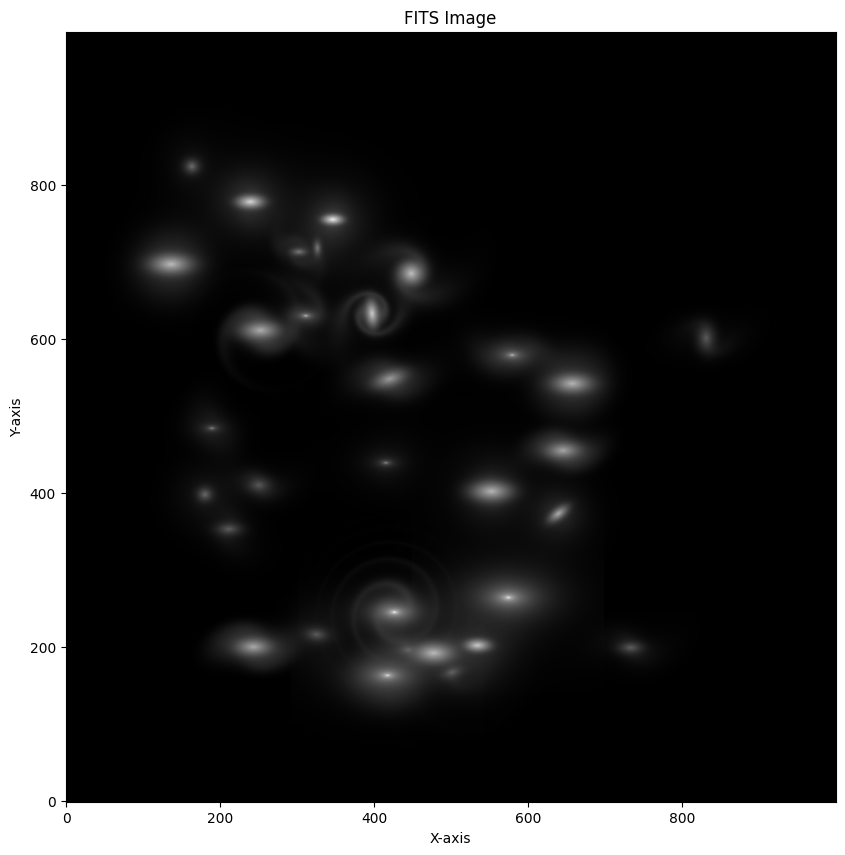

In [9]:
if __name__ == "__main__":
    plt.clf()
    
    # Hyperparameters
    g_prefix = "galaxy"
    g_number = 0
    
    cwd = Path.cwd()
    
    IN_DIR  = pj(cwd, "music-in")
    TMP_DIR = pj(cwd, "music-tmp")
    OUT_DIR = pj(cwd, "music-out")
    
    gname = "template"
    music_filename = "brown_alma_mater.mp3"
    
    height = 1000
    width  = 1000
    # square
    model_dim    = 250
    model_offset = model_dim//2

    # Change this to None to get a seed based on the current time
    initial_seed_value = 42
    
    # Make an output folder for the 'galaxy'
    # This follows SpArcFiRe convention of which 
    # the galfitlib was initially designed for
    if not exists(pj(OUT_DIR, gname)):
        pj(OUT_DIR, gname).mkdir()
    
    feedme_0          = pj(OUT_DIR, gname, f"{gname}.in")
    input_filename_0  = pj(IN_DIR, f"{gname}.fits")
    output_filename_0 = pj(OUT_DIR, gname, f"{gname}.fits")
    
    # Wait half a second before starting the analysis
    delay = 0.5
    signal, sample_rate, time_array = load_audio(music_filename, delay = delay)
    
    # Process every 2 seconds of the song
    time_step   = 2
    t_step_size = time_step * sample_rate
    t_initial   = int(delay * sample_rate) + t_step_size
        
    # Initializing some lists
    list_o_notes = []
    volumes      = []
    
    # Written as such to prepare for async processing
    for t_step in range(t_initial, len(time_array), t_step_size):
        
        signal_cut = signal[t_step - t_step_size : t_step]
        
        # Select frequency peaks and get RMS volume
        selected_peaks, volume = time_step_analysis(signal_cut, sample_rate)
        if selected_peaks is None:
            continue
            
        # Search for notes by their frequency range using the selected frequency peaks
        peak_notes = binary_search_ranges(note_ranges_for_search, selected_peaks)
        
        # Store        
        list_o_notes.append(peak_notes)
        volumes.append(volume)
    
    # Flatten the list of lists of notes for Counter
    flattened_list_o_notes = [note[0] for sublist in list_o_notes for note in sublist]
    
    # Counter does not sort by frequency, so we need to sort it
    sorted_counter = {
        k : v for k, v in sorted(
                Counter(flattened_list_o_notes).items(), key=lambda item: item[1], 
                reverse = True
        )
    }
    
    # Map notes to how number indicating often they show up in the Fourier analysis
    # aka their 'priority number'
    note_priority_map = {
        note : priority_num
        for priority_num, note in enumerate(
                sorted_counter.keys()
        )
    }
    
    # Normalize volumes
    volumes      = np.array(volumes)
    max_volume   = np.max(volumes)
    min_volume   = np.min(volumes)
    norm_volumes = (volumes - min_volume)/(1 + max_volume - min_volume)
    
    # Initialize model generation loop
    image_array = np.zeros((height, width))
    seed_value  = initial_seed_value
    for i, (notes_chunk, norm_volume) in enumerate(zip(list_o_notes, norm_volumes)):
        
        # Leaving this as such can allow me to debug things later
        # Based on their coordinates in the image
        seed(seed_value)
        x_pos = randint(model_offset, width  - model_offset)
        y_pos = randint(model_offset, height - model_offset)
        seed_value += 1
        
        # Run GALFIT!
        output_filename = galfitting(
                feedme_0, 
                input_filename_0, 
                output_filename_0, 
                gname,
                x_pos, 
                y_pos, 
                model_offset,
                note_priority_map,
                notes_chunk, 
                norm_volume, 
                i
        )
        
        # Process the output and update the array used to create the final image
        image_array += process_galfit_output(
                output_filename, 
                height, 
                width,
                x_pos, 
                y_pos,
                model_dim,
                model_offset
        )
        
    # Create the galaxy mosaic
    _ = generate_mosaic(image_array)
        